# Setting Up Gym Environment

In [1]:
import gym

## Cartpole Environment

In [2]:
env = gym.make('CartPole-v0')

The rendered window env might stay unresponsive and some say this is due to jupyter notebook visualization problems.  
Looking for a way to solve this.

In [3]:
env.reset()
# let's see 10 timesteps with random action
for _ in range(10):
    # env.render()
    observation, reward, done, info = env.step(env.action_space.sample())
    print(observation, reward, done, info)
    if done:
        break
# env.close()

[ 0.02699665 -0.24144292 -0.04998176  0.24238946] 1.0 False {}
[ 0.02216779 -0.43581662 -0.04513397  0.51889735] 1.0 False {}
[ 0.01345146 -0.24008925 -0.03475602  0.21234043] 1.0 False {}
[ 0.00864967 -0.04448806 -0.03050921 -0.09110037] 1.0 False {}
[ 0.00775991 -0.23915973 -0.03233122  0.19180292] 1.0 False {}
[ 0.00297671 -0.04359054 -0.02849516 -0.11090128] 1.0 False {}
[ 0.0021049   0.15192789 -0.03071319 -0.41243634] 1.0 False {}
[ 0.00514346  0.34747145 -0.03896192 -0.7146416 ] 1.0 False {}
[ 0.01209289  0.5431105  -0.05325475 -1.0193293 ] 1.0 False {}
[ 0.0229551   0.7389002  -0.07364134 -1.3282471 ] 1.0 False {}


Using GIF looks possible : https://rrbb014.tistory.com/44#openai-gym%EC%9D%84-jupyter-notebook%ED%99%98%EA%B2%BD%EC%97%90%EC%84%9C-%EC%8B%A4%ED%96%89%ED%95%98%EA%B8%B0-headless-playing

## Matplotlib will be used for visualizing results

When the whole training is going on, the graph will be the mean survived timesteps for each epochs.

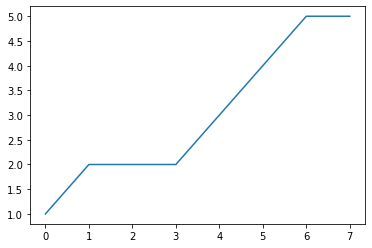

In [4]:
import matplotlib.pyplot as plt
plt.plot([1,2,2,2,3,4,5,5])

## pytorch

In [5]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np

Simple Linear NN for the policy. It is from a code in CS285 lecture 3, except it uses softmax at the output layer.

In [6]:
class Net(nn.Module):
    def __init__(self, input_size=4, output_size=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x      

In [7]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


# Mathematics

$$
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=1}^{T} \nabla_\theta \log{\pi_\theta \left( a_{i,t} | s_{i,t} \right)}  \left( \sum_{t^\prime=t}^{T} r\left( s_{i,t}, a_{i,t} \right) \right) \\
J(\theta) = E_{\tau~p_\theta(\tau)}\left[ \sum_{t}r(s_t, a_t) \right] \approx \frac{1}{N}\sum_i\sum_{t}r(s_{i,t}, a_{i,t}) \\
\tilde{J}(\theta) \approx \frac{1}{N}\sum_{i=1}^N\sum_{t=1}^T \log{\pi_\theta \left( a_{i,t} | s_{i,t} \right)} \hat{Q}_{i,t} \\
$$

$-\tilde{J}(\theta)$ will be used as the loss function

# The codes that will run to train

In [9]:
from tqdm import tqdm # to visualize the progress
N = 1000 # number of samples(trajectories) for each iteration
max_traj_len = 100 # T(max length of the trajectory)
net = Net()

# loss function is -(J tilde) (on the equation above)
def loss_fn(net_val, q_val):
    return -(torch.sum(torch.log(net_val) * q_val, dim=-1)) / N

# using Adam optimizer (because in the lecture it was mentioned to be okay)
# the learning rate is from the codes of lecture 3
optimizer = optim.Adam(net.parameters(), lr=1e-3)

## run the policy to create N samples

In [10]:
# new samples for every update, because VPG is an On-policy algorithm
samples = []

for sample_i in tqdm(range(N)):
    # initial state
    observation = env.reset()
    one_traj = []
    for traj_step in range(max_traj_len):
        # env.render()
        action = net(torch.from_numpy(observation)).detach().numpy().argmax()
        observation, reward, done, info = env.step(action)
        one_traj.append([observation, action, reward])
        if done or traj_step == (max_traj_len - 1):
            samples.append(one_traj)
            break
# env.close()

100%|██████████| 1000/1000 [00:02<00:00, 493.77it/s]


In [11]:
# Getting the q-values(reward to go)
q_values = []
for sample in samples:
    temp = []
    for i in range(len(sample)):
        q = 0
        for t in range(i, len(sample)):
            q += sample[t][2]
        temp.append(q)
    q_values.append(temp)

In [12]:
# appending the q_values to the 'samples' list
for i in range(len(q_values)):
    for j in range(len(q_values[i])):
        samples[i][j].append(q_values[i][j])

In [13]:
# shape of the list 'samples' => [trajectory][state, action, reward, q_value(reward to go)]
# making a list(soon will be changed to tensors) for actions, states, q_values
actions = []
states = []
q_values = []
for sample in samples:
    for state, action, reward, q_value in sample:
        states.append(state)
        actions.append(action)
        q_values.append(q_value)

actions = torch.from_numpy(np.array(actions))
states = torch.from_numpy(np.array(states))
q_values = torch.from_numpy(np.array(q_values))
net_values = net(states).max(dim=1).values

## backprop

In [15]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

# All the codes for learning

In [49]:
N = 10000
max_traj_len = 100 # T
net = Net()

def loss_fn(net_val, q_val):
    return (torch.sum(torch.log(net_val) * q_val)) / N

optimizer = optim.Adam(net.parameters(), lr=1e-3)

lasted_times = []
losses = []


# epoch size
epoch_size = 50
for _ in tqdm(range(epoch_size)):
    samples = [] # new samples, because VPG is on policy algo
    one_epoch_lasted_times = []
    for sample_i in range(N):
        # initial state
        observation = env.reset()
        one_traj = []
        for traj_step in range(max_traj_len):
            # env.render()
            action = net(torch.from_numpy(observation)).detach().numpy().argmax()
            observation, reward, done, info = env.step(action)
            one_traj.append([observation, action, reward])
            if done or traj_step == (max_traj_len - 1):
                samples.append(one_traj)
                one_epoch_lasted_times.append(traj_step + 1)
                break
    lasted_times.append(sum(one_epoch_lasted_times) / len(one_epoch_lasted_times))
                
    # env.close()
    # Getting the q-values(reward to go)
    q_values = []
    for sample in samples:
        temp = []
        for i in range(len(sample)):
            q = 0
            for t in range(i, len(sample)):
                q += sample[t][2]
            temp.append(q)
        q_values.append(temp)
    
    # appending the q values to the samples list
    for i in range(len(q_values)):
        for j in range(len(q_values[i])):
            samples[i][j].append(q_values[i][j])
    
    # sample shape => [trajectory][state, action, reward, q_value(reward to go)]
    # make torch.tensors for actions, states, q_values
    actions = []
    states = []
    q_values = []
    for sample in samples:
        for state, action, reward, q_value in sample:
            states.append(state)
            actions.append(action)
            q_values.append(q_value)

    actions = torch.from_numpy(np.array(actions))
    states = torch.from_numpy(np.array(states))
    q_values = torch.from_numpy(np.array(q_values))
    net_values = net(states).max(dim=1).values
    
    loss = loss_fn(net_val=net_values, q_val=q_values)
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 50/50 [28:32<00:00, 34.26s/it] 


# Visualize the lasted time for Epochs

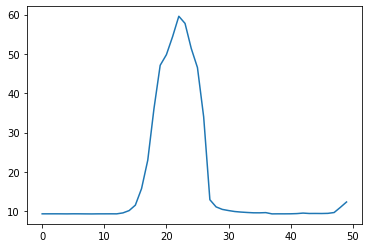

In [50]:
import matplotlib.pyplot as plt
plt.plot(lasted_times);

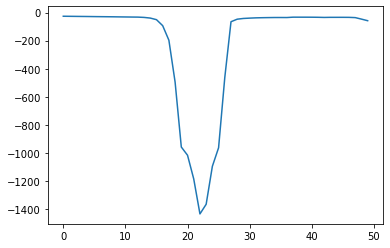

In [52]:
plt.plot(losses);